In [2]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import albumentations as A
import time
from tqdm import tqdm

In [4]:
import os

# Get the list of fruit names from the Test folder
fruit_names = os.listdir('Test/')
print(fruit_names)

# Form a dictionary to store fruit information
obj_dict = {}
for idx, fruit_name in enumerate(fruit_names, start=1):
    obj_dict[idx] = {'folder': fruit_name, 'longest_min': 150, 'longest_max': 800}




#files_bg_imgs = sorted(os.listdir(os.path.join('Data\\Back Ground', 'bg')))
#files_bg_imgs = [os.path.join('Data\\Back Ground', 'bg', f) for f in files_bg_imgs]







['Apple Braeburn', 'Apple Crimson Snow', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Pink Lady', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Lady Finger', 'Banana Red', 'Beetroot', 'Blueberry', 'Cactus fruit', 'Cantaloupe 1', 'Cantaloupe 2', 'Carambula', 'Cauliflower', 'Cherry 1', 'Cherry 2', 'Cherry Rainier', 'Cherry Wax Black', 'Cherry Wax Red', 'Cherry Wax Yellow', 'Chestnut', 'Clementine', 'Cocos', 'Corn', 'Corn Husk', 'Cucumber Ripe', 'Cucumber Ripe 2', 'Dates', 'Eggplant', 'Fig', 'Ginger Root', 'Granadilla', 'Grape Blue', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grape White 3', 'Grape White 4', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Hazelnut', 'Huckleberry', 'Kaki', 'Kiwi', 'Kohlrabi', 'Kumquats', 'Lemon', 'Lemon Meyer', 'Limes', 'Lychee', 'Mandarine', 'Mango', 'Mango Red', 'Mangostan', 'Maracuja', 'Melo

In [5]:
import os

# Get the list of fruit names from the Test folder
fruit_names = os.listdir('Test/')

# Form a dictionary to store fruit information
obj_dict = {}
for idx, fruit_name in enumerate(fruit_names, start=1):
    obj_dict[idx] = {
        'folder': fruit_name,
        'longest_min': 150,
        'longest_max': 800,
        'images': sorted(os.listdir(os.path.join('Data/New Dataset', fruit_name))),
        'masks': sorted(os.listdir(os.path.join('Data/Masked New Dataset', fruit_name)))
    }





In [6]:
import cv2
import numpy as np

def form_binary_mask(mask, threshold_value):
    red_channel = mask[:, :, 0]
    binary_mask = (red_channel <= threshold_value).astype(np.uint8)
    return binary_mask

def get_img_and_mask(image_path, mask_path, threshold_value=150):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    binary_mask = form_binary_mask(mask, threshold_value)
    
    return image, binary_mask


Image file: Data/New Dataset/Pear Kaiser\145_100.jpg
Mask file: Data/Masked New Dataset/Pear Kaiser\145_100.jpg

Shape of the image of the object: (100, 100, 3)
Shape of the binary mask: (100, 100)


Text(0.5, 1.0, 'Binary mask')

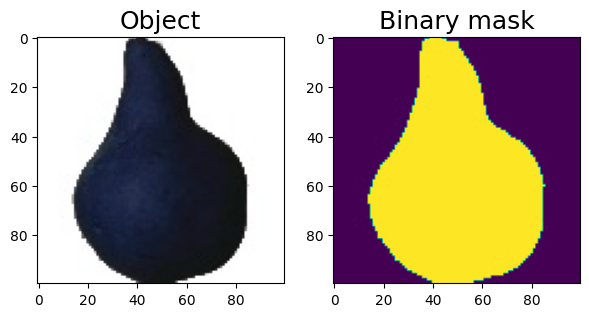

In [27]:
# Let's look at a random object and its binary mask
import random

# Veri klasörü yolları
data_path = 'Data/New Dataset/'
mask_path = 'Data/Masked New Dataset/'

selected_obj = random.choice(list(obj_dict.keys()))
selected_folder = obj_dict[selected_obj]['folder']
selected_image = random.choice(obj_dict[selected_obj]['images'])

img_path = os.path.join(data_path, selected_folder, selected_image)
mask_path = os.path.join(mask_path, selected_folder, selected_image)

img, mask = get_img_and_mask(img_path, mask_path)

print("Image file:", img_path)
print("Mask file:", mask_path)
print("\nShape of the image of the object:", img.shape)
print("Shape of the binary mask:", mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Binary mask', fontsize=18)

In [28]:
def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t

transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3,
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.5)
])

transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])

Shape of the image of the transformed object: (395, 395, 3)
Shape of the transformed binary mask: (395, 395)




Text(0.5, 1.0, 'Transformed binary mask')

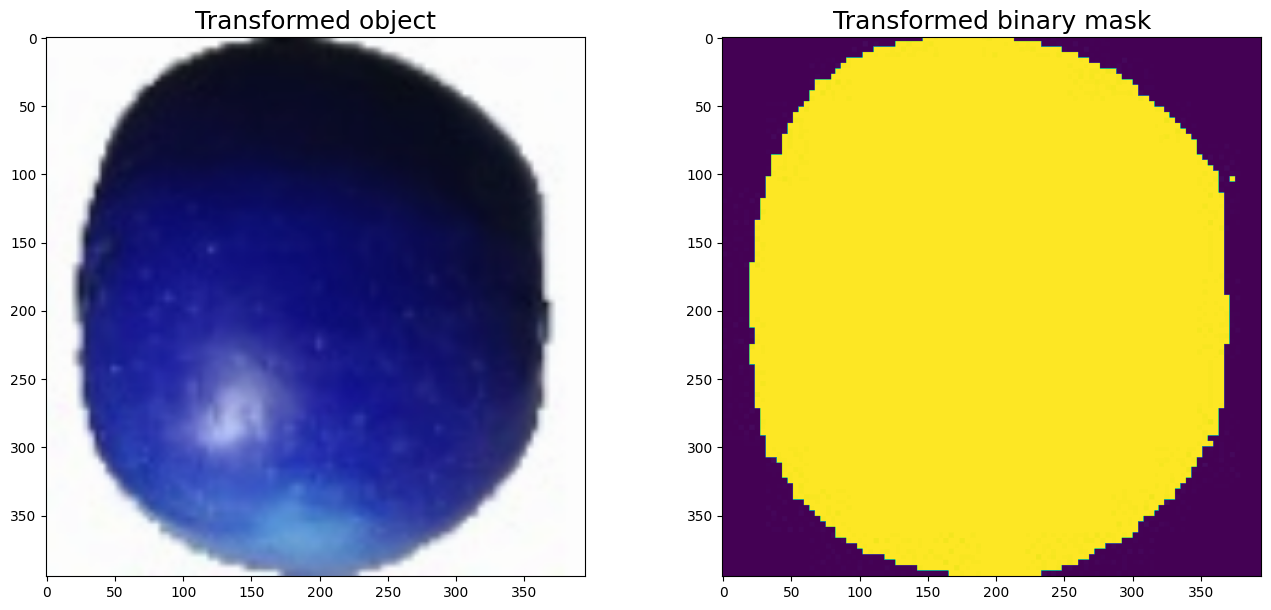

In [29]:
# Let's look how image and binary mask of a random object can be transformed
# with help of resize_transform_obj() function

img_path = 'Data/New Dataset/' + obj_dict[1]['folder'] + '/' + obj_dict[1]['images'][0]
mask_path = 'Data/Masked New Dataset/' + obj_dict[1]['folder'] + '/' + obj_dict[1]['images'][0]

img, mask = get_img_and_mask(img_path, mask_path)

img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     longest_min=300,
                                     longest_max=400,
                                     transforms=transforms_obj)

print("Shape of the image of the transformed object:", img_t.shape)
print("Shape of the transformed binary mask:", mask_t.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_t)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(mask_t)
ax[1].set_title('Transformed binary mask', fontsize=18)